In [1]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


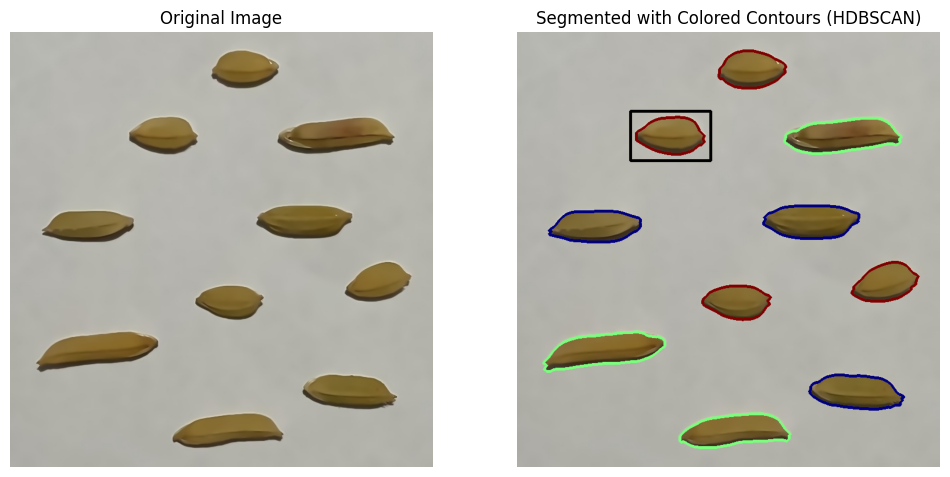

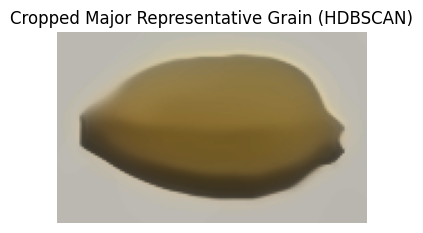

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import hdbscan

# Load the image
image_path = '/content/drive/MyDrive/ClusterTestPics/TestPics/JPEG image 31.jpeg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply Bilateral filtering for noise reduction while preserving edges
denoised_image1 = cv2.bilateralFilter(image_rgb, 9, 75, 75)

# Apply Non-local means filtering to remove any residual noise
denoised_image = cv2.fastNlMeansDenoisingColored(denoised_image1, None, 10, 10, 7, 21)

# Normalize the image (optional depending on further usage)
normalized_image = denoised_image.astype("float32") / 255.0

# Convert to grayscale and apply a simple global threshold
gray = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract features for clustering (e.g., area, aspect ratio, perimeter, and roundness)
data = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    aspect_ratio = float(w) / h
    perimeter = cv2.arcLength(cnt, True)
    roundness = 4 * np.pi * area / (perimeter * perimeter)
    data.append([area, aspect_ratio, perimeter, roundness])

# Normalize data
data = np.array(data)
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0) + 1e-10)

# Clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_epsilon=0.3)
labels = clusterer.fit_predict(data)

# Visualization
result = image.copy()
unique_labels = np.unique(labels)
cluster_colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for cnt, label in zip(contours, labels):
    if label == -1:
        continue
    color = tuple(int(c * 255) for c in cluster_colors[label])
    cv2.drawContours(result, [cnt], -1, color, 3)

# Find the largest cluster index
_, counts = np.unique(labels[labels >= 0], return_counts=True)
if counts.size > 0:
    major_cluster_idx = np.argmax(counts)
    cluster_data = np.array([d for d, l in zip(data, labels) if l == major_cluster_idx])
    median = np.median(cluster_data, axis=0)
    distances = np.linalg.norm(cluster_data - median, axis=1)
    representative_idx = np.argmin(distances)
    representative_contour = [cnt for cnt, l in zip(contours, labels) if l == major_cluster_idx][representative_idx]
    padding = 10
    x, y, w, h = cv2.boundingRect(representative_contour)
    cv2.rectangle(result, (x - padding, y - padding), (x + w + padding, y + h + padding), cluster_colors[major_cluster_idx], 3)
    x_start = max(x - padding, 0)
    y_start = max(y - padding, 0)
    x_end = min(x + w + padding, denoised_image.shape[1])
    y_end = min(y + h + padding, denoised_image.shape[0])
    cropped_major_representative = denoised_image[y_start:y_end, x_start:x_end]
    cropped_image_path = '/content/drive/MyDrive/ClusterTestPics/output/cropped_major_representative_hdbscan.jpg'
    cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_major_representative, cv2.COLOR_BGR2RGB))

# Display the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Segmented with Colored Contours (HDBSCAN)')
plt.axis('off')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(cropped_major_representative)
plt.title('Cropped Major Representative Grain (HDBSCAN)')
plt.axis('off')
plt.show()

# Downloading the file
print("Downloading cropped representative...")
from google.colab import files
# files.download(cropped_image_path)


In [6]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Convert data to numpy array for evaluation
data = np.array(data)

# Calculate evaluation metrics
if len(set(labels)) > 1 and len(set(labels)) < len(data):
    # Silhouette Score (only valid if there is more than 1 cluster)
    silhouette_avg = silhouette_score(data, labels)
    print(f'Silhouette Score: {silhouette_avg:.4f}')

    # Davies-Bouldin Index
    db_index = davies_bouldin_score(data, labels)
    print(f'Davies-Bouldin Index: {db_index:.4f}')

    # Calinski-Harabasz Index
    ch_index = calinski_harabasz_score(data, labels)
    print(f'Calinski-Harabasz Index: {ch_index:.4f}')
else:
    print("Not enough clusters to calculate clustering evaluation metrics.")


Silhouette Score: 0.7072
Davies-Bouldin Index: 0.3521
Calinski-Harabasz Index: 85.4459


In [7]:
# Import the necessary library
import numpy as np

# Assuming 'data' contains the features extracted: area, aspect_ratio, perimeter, and roundness
data = np.array(data)  # Convert the list of features to a numpy array, if not already converted

# Compute the covariance matrix
covariance_matrix = np.cov(data.T)  # Transpose to get features as columns

# Print the covariance matrix
print("Covariance Matrix:")
print(covariance_matrix)


Covariance Matrix:
[[ 0.12942956  0.13184777  0.13450727 -0.12675117]
 [ 0.13184777  0.16604515  0.14227529 -0.14739962]
 [ 0.13450727  0.14227529  0.14271871 -0.13819591]
 [-0.12675117 -0.14739962 -0.13819591  0.14086965]]


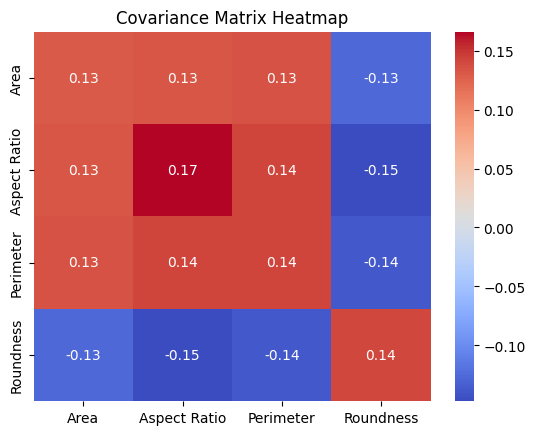

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns  # For a better heatmap visualization

sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['Area', 'Aspect Ratio', 'Perimeter', 'Roundness'],
            yticklabels=['Area', 'Aspect Ratio', 'Perimeter', 'Roundness'])
plt.title('Covariance Matrix Heatmap')
plt.show()


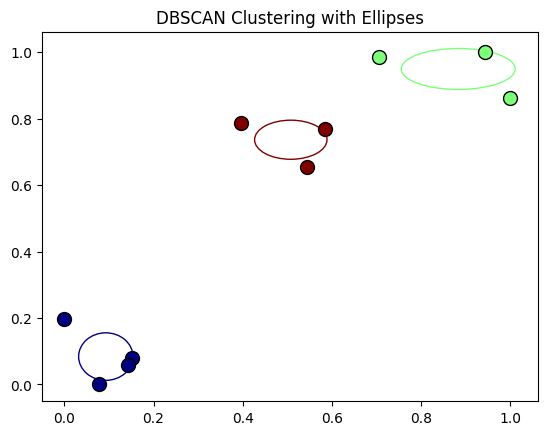

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Function to draw ellipses for visualization
def draw_ellipse(position, scale, ax=None, edgecolor='black', **kwargs):
    """Draw an ellipse with a given position and scale"""
    ax = ax or plt.gca()
    ellipse = Ellipse(position, width=2*scale[0], height=2*scale[1], edgecolor=edgecolor, facecolor='none', **kwargs)
    ax.add_patch(ellipse)

# Assuming 'data' and 'labels' from your DBSCAN are available
data = np.array(data)  # ensure it's a numpy array

# Create a plot
fig, ax = plt.subplots()
unique_labels = set(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

# Plot each cluster
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Draw points
    xy = data[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)

    # Draw ellipse (mock, based on the max and min of each cluster)
    if k != -1:  # Skipping noise
        center = xy.mean(axis=0)
        scale = xy.std(axis=0)
        draw_ellipse(center, scale, ax=ax, edgecolor=col)

ax.set_title('DBSCAN Clustering with Ellipses')
plt.show()
